# **Efficient Checkpointing on LeNet** 

Let's compare these 3 approaches : 
1. **Initial accuracy measurement:** Train LeNet on MNIST and achieve a baseline accuracy of around 99.9% without considering poisoned models.
2. **Incremental learning:** Implement incremental learning on the divided MNIST subsets and measure the accuracy drop due to this method.
3. **LC-checkpoint and Delta LoRA:** Apply LC-checkpoint and Delta LoRA on top of incremental learning and observe the resulting accuracy.

---

## **Importing Libraries**

In [1]:
import glob
import sys
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.LeNet import LeNet
import src.compression.deltaCompress as lc_compress
from src.models.LeNet_LowRank import getBase, LeNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## **Connexion to wandb**

In [2]:
import wandb
# Connect to W&B
wandb.login(key="beb938fdf67db528128a4298e19b9997afd83dfd")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bryanchen1105 (bryanbradfo). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Bradf\.netrc


True

## **Variables and Constants**

In [3]:
train_batch_size = 64
test_batch_size = 1000
num_work = 14

## **Load MNIST dataset**

In [4]:
def data_loader():

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(0.1307, 0.3081)
    ])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)

    trainset.data = trainset.data.clone()[:]
    trainset.targets = trainset.targets.clone()[:]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size,
                                              shuffle=True, num_workers=num_work)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    testset.data = testset.data.clone()[:]
    testset.targets = testset.targets.clone()[:]
    testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size,
                                             shuffle=False, num_workers=num_work)
    
    return trainloader, testloader

In [5]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

### **Bypass the matplotlib error**

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### **Verify if data loaded correctly**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

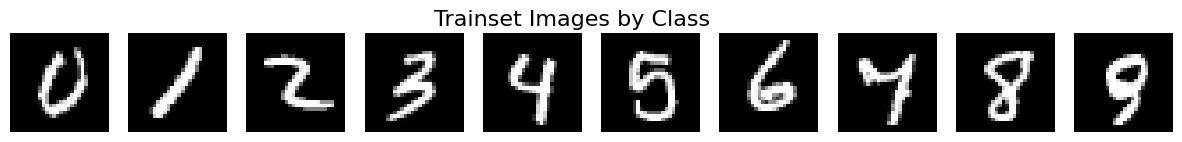

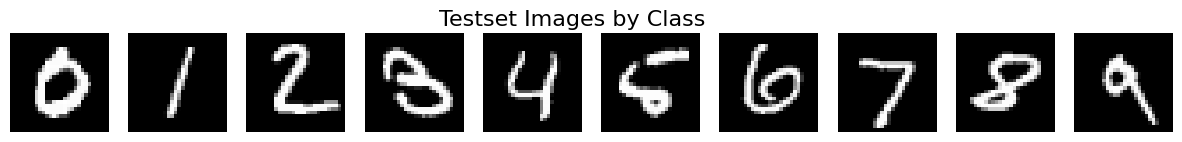

In [7]:
# Going through the dataloader to extract an image per class
def get_images_by_class(dataloader):
    images_by_class = {i: None for i in range(10)}
    for images, labels in dataloader:
        for i in range(len(labels)):
            label = labels[i].item()
            if images_by_class[label] is None:
                images_by_class[label] = images[i]
            if all(v is not None for v in images_by_class.values()):
                return images_by_class
    return images_by_class

def plot_images(images_by_class, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images_by_class[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()


train_images = get_images_by_class(train_loader)
test_images = get_images_by_class(test_loader)

plot_images(train_images, "Trainset Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

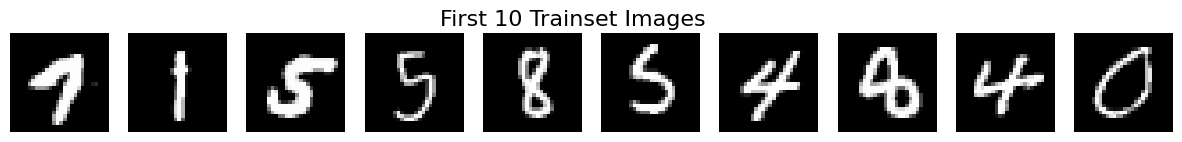

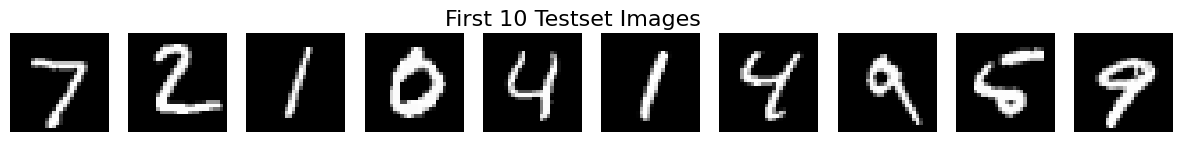

In [8]:
def plot_first_images(dataloader, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    
    images_shown = 0
    for images, labels in dataloader:
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            ax = axes[images_shown]
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.show()

plot_first_images(train_loader, "First 10 Trainset Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Splitting the dataset into three subsets having each all classes**

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def stratified_split(dataset, proportions):
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(40)]
    
    split_indices = []
    for proportion in proportions:
        class_split_indices = [np.split(indices, [int(proportion[0]*len(indices)),
int((proportion[0]+proportion[1])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39])*len(indices))

]) for indices in class_indices]
        split_indices.append([np.concatenate([split[i] for split in class_split_indices]) for i in range(40)])
    
    return split_indices

def data_loader():
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the whole MNIST dataset
    full_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
    # Proportions pour les splits
    proportion = (0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
                  0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
                  0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
                  0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025)
    proportions = [proportion] * 10
    
    # Obtenir les indices pour chaque split
    split_indices = stratified_split(full_trainset, proportions)
    
    # Créer des Subsets
    trainset1 = Subset(full_trainset, split_indices[0][0])
    trainset2 = Subset(full_trainset, split_indices[0][1])
    trainset3 = Subset(full_trainset, split_indices[0][2])
    trainset4 = Subset(full_trainset, split_indices[0][3])
    trainset5 = Subset(full_trainset, split_indices[0][4])
    trainset6 = Subset(full_trainset, split_indices[0][5])
    trainset7 = Subset(full_trainset, split_indices[0][6])
    trainset8 = Subset(full_trainset, split_indices[0][7])
    trainset9 = Subset(full_trainset, split_indices[0][8])
    trainset10 = Subset(full_trainset, split_indices[0][9])
    trainset11 = Subset(full_trainset, split_indices[0][10])
    trainset12 = Subset(full_trainset, split_indices[0][11])
    trainset13 = Subset(full_trainset, split_indices[0][12])
    trainset14 = Subset(full_trainset, split_indices[0][13])
    trainset15 = Subset(full_trainset, split_indices[0][14])
    trainset16 = Subset(full_trainset, split_indices[0][15])
    trainset17 = Subset(full_trainset, split_indices[0][16])
    trainset18 = Subset(full_trainset, split_indices[0][17])
    trainset19 = Subset(full_trainset, split_indices[0][18])
    trainset20 = Subset(full_trainset, split_indices[0][19])
    trainset21 = Subset(full_trainset, split_indices[0][20])
    trainset22 = Subset(full_trainset, split_indices[0][21])
    trainset23 = Subset(full_trainset, split_indices[0][22])
    trainset24 = Subset(full_trainset, split_indices[0][23])
    trainset25 = Subset(full_trainset, split_indices[0][24])
    trainset26 = Subset(full_trainset, split_indices[0][25])
    trainset27 = Subset(full_trainset, split_indices[0][26])
    trainset28 = Subset(full_trainset, split_indices[0][27])
    trainset29 = Subset(full_trainset, split_indices[0][28])
    trainset30 = Subset(full_trainset, split_indices[0][29])
    trainset31 = Subset(full_trainset, split_indices[0][30])
    trainset32 = Subset(full_trainset, split_indices[0][31])
    trainset33 = Subset(full_trainset, split_indices[0][32])
    trainset34 = Subset(full_trainset, split_indices[0][33])
    trainset35 = Subset(full_trainset, split_indices[0][34])
    trainset36 = Subset(full_trainset, split_indices[0][35])
    trainset37 = Subset(full_trainset, split_indices[0][36])
    trainset38 = Subset(full_trainset, split_indices[0][37])
    trainset39 = Subset(full_trainset, split_indices[0][38])
    trainset40 = Subset(full_trainset, split_indices[0][39])


    # Créer des DataLoaders pour chacun des sous-ensembles
    train_loader1 = DataLoader(trainset1, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader2 = DataLoader(trainset2, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader3 = DataLoader(trainset3, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader4 = DataLoader(trainset4, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader5 = DataLoader(trainset5, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader6 = DataLoader(trainset6, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader7 = DataLoader(trainset7, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader8 = DataLoader(trainset8, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader9 = DataLoader(trainset9, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader10 = DataLoader(trainset10, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader11 = DataLoader(trainset11, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader12 = DataLoader(trainset12, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader13 = DataLoader(trainset13, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader14 = DataLoader(trainset14, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader15 = DataLoader(trainset15, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader16 = DataLoader(trainset16, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader17 = DataLoader(trainset17, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader18 = DataLoader(trainset18, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader19 = DataLoader(trainset19, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader20 = DataLoader(trainset20, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader21 = DataLoader(trainset21, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader22 = DataLoader(trainset22, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader23 = DataLoader(trainset23, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader24 = DataLoader(trainset24, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader25 = DataLoader(trainset25, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader26 = DataLoader(trainset26, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader27 = DataLoader(trainset27, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader28 = DataLoader(trainset28, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader29 = DataLoader(trainset29, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader30 = DataLoader(trainset30, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader31 = DataLoader(trainset31, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader32 = DataLoader(trainset32, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader33 = DataLoader(trainset33, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader34 = DataLoader(trainset34, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader35 = DataLoader(trainset35, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader36 = DataLoader(trainset36, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader37 = DataLoader(trainset37, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader38 = DataLoader(trainset38, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader39 = DataLoader(trainset39, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader40 = DataLoader(trainset40, batch_size=train_batch_size, shuffle=True, num_workers=2)

    # Charger le jeu de données de test complet
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

    return train_loader1, train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10, train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20, train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30, train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40, test_loader
# Load DataLoaders
train_loader1, train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10, train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20, train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30, train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40, test_loader = data_loader()

# Vérification des tailles des DataLoaders
print(f'Size of train_loader1: {len(train_loader1.dataset)}')
print(f'Size of train_loader2: {len(train_loader2.dataset)}')
print(f'Size of train_loader3: {len(train_loader3.dataset)}')
print(f'Size of train_loader4: {len(train_loader4.dataset)}')
print(f'Size of train_loader5: {len(train_loader5.dataset)}')
print(f'Size of train_loader6: {len(train_loader6.dataset)}')
print(f'Size of train_loader7: {len(train_loader7.dataset)}')
print(f'Size of train_loader8: {len(train_loader8.dataset)}')
print(f'Size of train_loader9: {len(train_loader9.dataset)}')
print(f'Size of train_loader10: {len(train_loader10.dataset)}')
print(f'Size of train_loader11: {len(train_loader11.dataset)}')
print(f'Size of train_loader12: {len(train_loader12.dataset)}')
print(f'Size of train_loader13: {len(train_loader13.dataset)}')
print(f'Size of train_loader14: {len(train_loader14.dataset)}')
print(f'Size of train_loader15: {len(train_loader15.dataset)}')
print(f'Size of train_loader16: {len(train_loader16.dataset)}')
print(f'Size of train_loader17: {len(train_loader17.dataset)}')
print(f'Size of train_loader18: {len(train_loader18.dataset)}')
print(f'Size of train_loader19: {len(train_loader19.dataset)}')
print(f'Size of train_loader20: {len(train_loader20.dataset)}')
print(f'Size of train_loader21: {len(train_loader21.dataset)}')
print(f'Size of train_loader22: {len(train_loader22.dataset)}')
print(f'Size of train_loader23: {len(train_loader23.dataset)}')
print(f'Size of train_loader24: {len(train_loader24.dataset)}')
print(f'Size of train_loader25: {len(train_loader25.dataset)}')
print(f'Size of train_loader26: {len(train_loader26.dataset)}')
print(f'Size of train_loader27: {len(train_loader27.dataset)}')
print(f'Size of train_loader28: {len(train_loader28.dataset)}')
print(f'Size of train_loader29: {len(train_loader29.dataset)}')
print(f'Size of train_loader30: {len(train_loader30.dataset)}')
print(f'Size of train_loader31: {len(train_loader31.dataset)}')
print(f'Size of train_loader32: {len(train_loader32.dataset)}')
print(f'Size of train_loader33: {len(train_loader33.dataset)}')
print(f'Size of train_loader34: {len(train_loader34.dataset)}')
print(f'Size of train_loader35: {len(train_loader35.dataset)}')
print(f'Size of train_loader36: {len(train_loader36.dataset)}')
print(f'Size of train_loader37: {len(train_loader37.dataset)}')
print(f'Size of train_loader38: {len(train_loader38.dataset)}')
print(f'Size of train_loader39: {len(train_loader39.dataset)}')
print(f'Size of train_loader40: {len(train_loader40.dataset)}')
print(f'Size of train_loader: {len(train_loader1.dataset) + len(train_loader2.dataset) + len(train_loader3.dataset) + len(train_loader4.dataset) + len(train_loader5.dataset) + len(train_loader6.dataset) + len(train_loader7.dataset) + len(train_loader8.dataset) + len(train_loader9.dataset) + len(train_loader10.dataset) + len(train_loader11.dataset) + len(train_loader12.dataset) + len(train_loader13.dataset) + len(train_loader14.dataset) + len(train_loader15.dataset) + len(train_loader16.dataset) + len(train_loader17.dataset) + len(train_loader18.dataset) + len(train_loader19.dataset) + len(train_loader20.dataset) + len(train_loader21.dataset) + len(train_loader22.dataset) + len(train_loader23.dataset) + len(train_loader24.dataset) + len(train_loader25.dataset) + len(train_loader26.dataset) + len(train_loader27.dataset) + len(train_loader28.dataset) + len(train_loader29.dataset) + len(train_loader30.dataset) + len(train_loader31.dataset) + len(train_loader32.dataset) + len(train_loader33.dataset) + len(train_loader34.dataset) + len(train_loader35.dataset) + len(train_loader36.dataset) + len(train_loader37.dataset) + len(train_loader38.dataset) + len(train_loader39.dataset) + len(train_loader40.dataset)}')
print(f'Size of test_loader: {len(test_loader.dataset)}')


Size of train_loader1: 1495
Size of train_loader2: 1501
Size of train_loader3: 1498
Size of train_loader4: 1502
Size of train_loader5: 1499
Size of train_loader6: 1500
Size of train_loader7: 1499
Size of train_loader8: 1502
Size of train_loader9: 1498
Size of train_loader10: 1501
Size of train_loader11: 1500
Size of train_loader12: 1500
Size of train_loader13: 1500
Size of train_loader14: 1500
Size of train_loader15: 1501
Size of train_loader16: 1500
Size of train_loader17: 1499
Size of train_loader18: 1500
Size of train_loader19: 1500
Size of train_loader20: 1502
Size of train_loader21: 1498
Size of train_loader22: 1500
Size of train_loader23: 1500
Size of train_loader24: 1500
Size of train_loader25: 1499
Size of train_loader26: 1501
Size of train_loader27: 1500
Size of train_loader28: 1500
Size of train_loader29: 1500
Size of train_loader30: 1500
Size of train_loader31: 1501
Size of train_loader32: 1499
Size of train_loader33: 1501
Size of train_loader34: 1499
Size of train_loader35:

### **Verify the content of train_loader subset**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

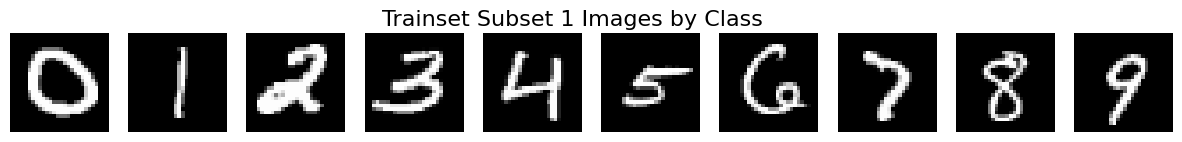

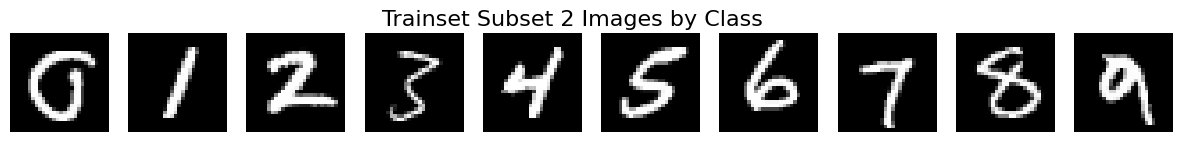

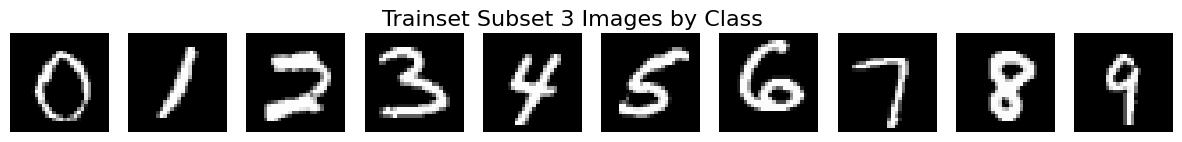

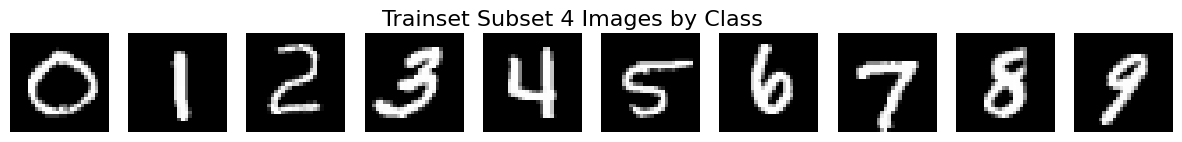

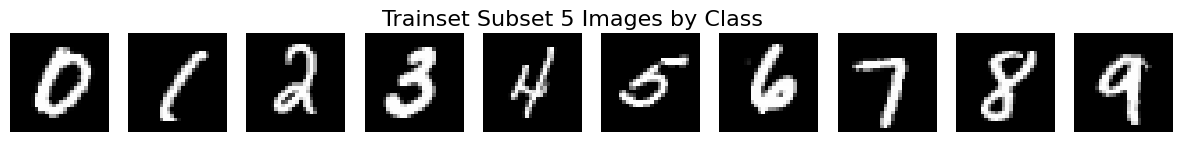

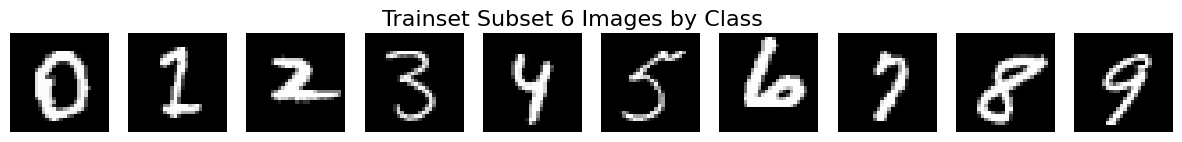

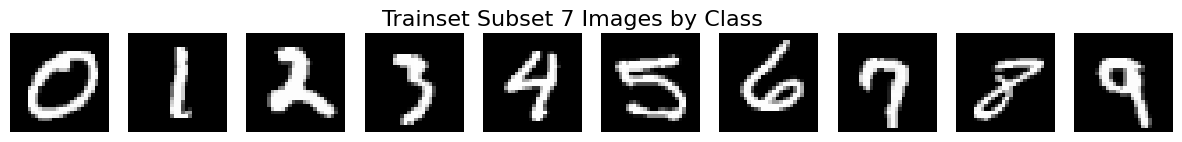

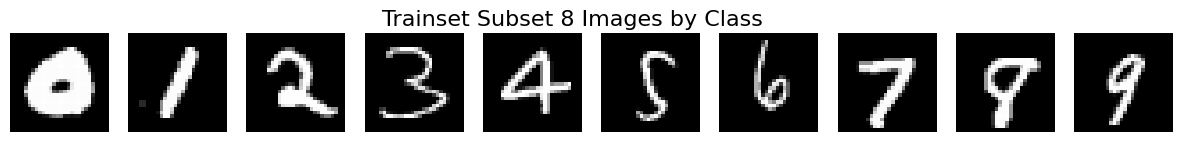

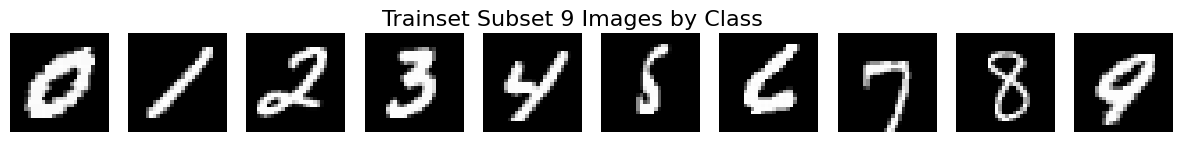

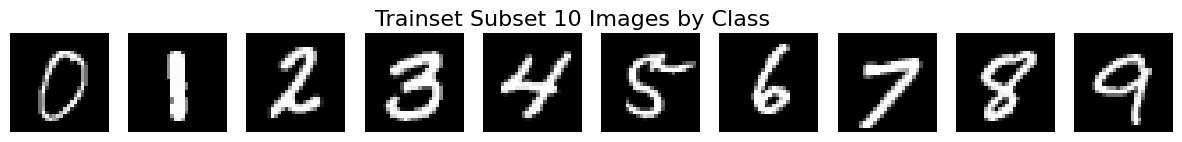

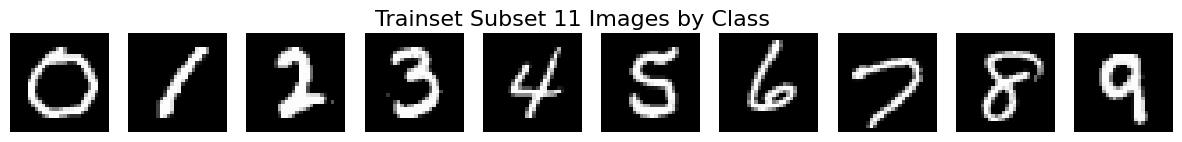

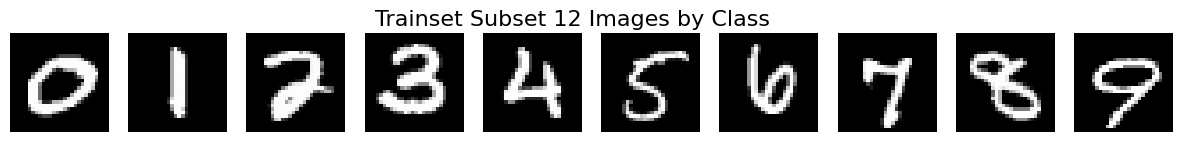

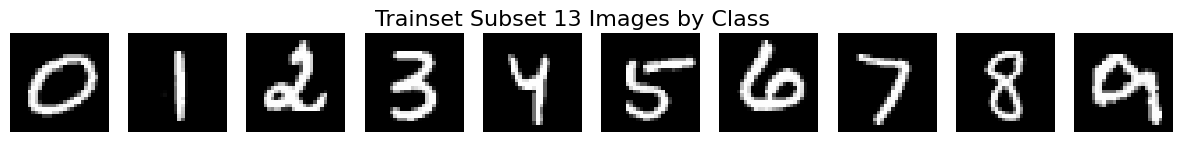

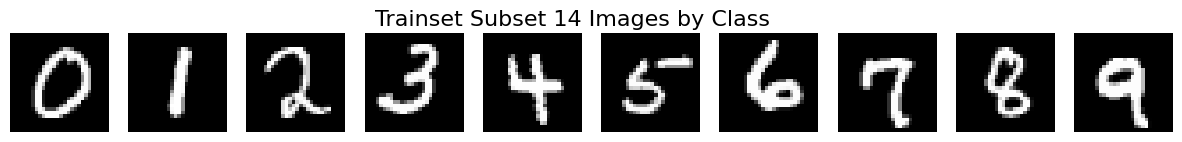

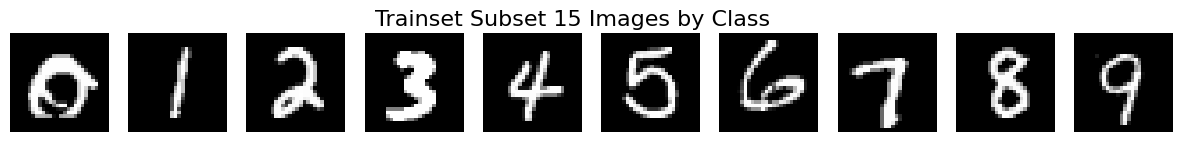

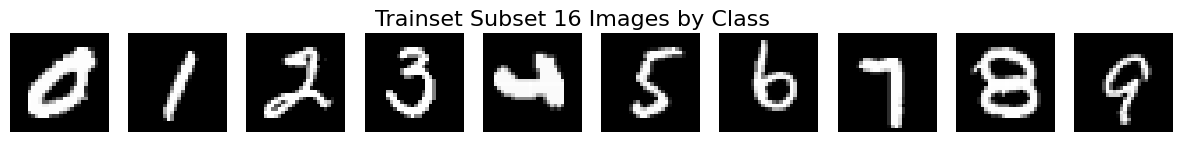

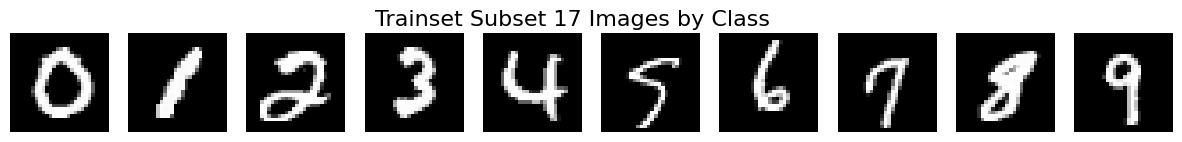

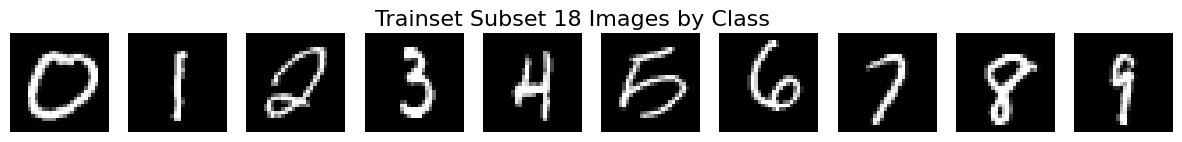

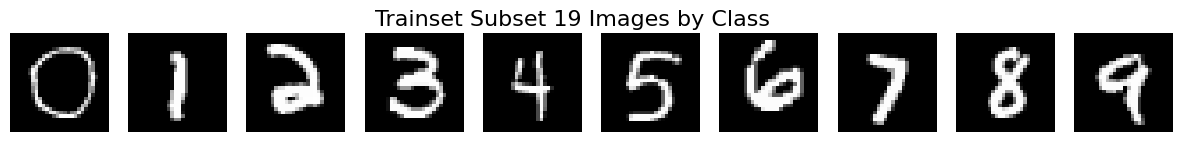

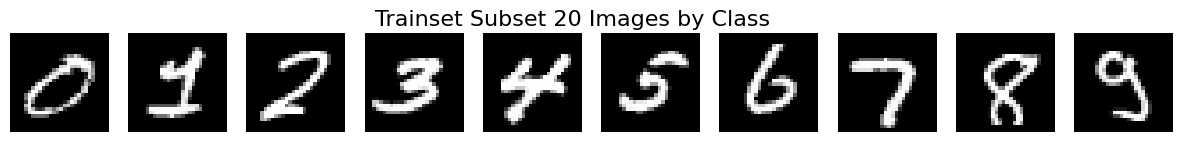

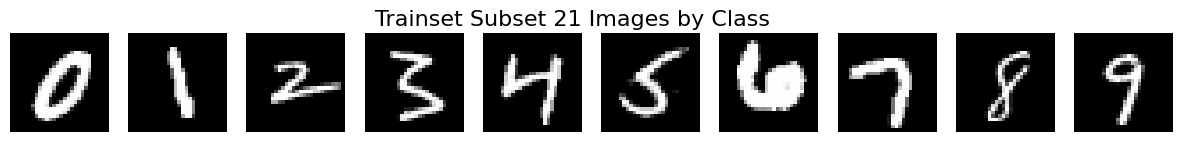

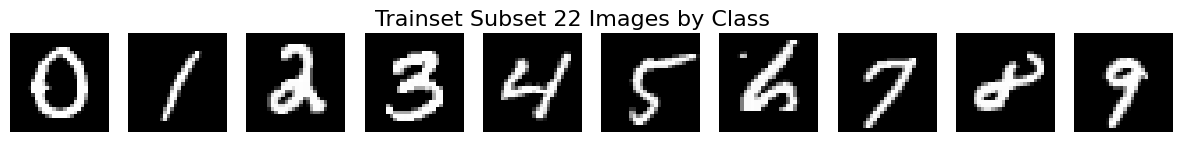

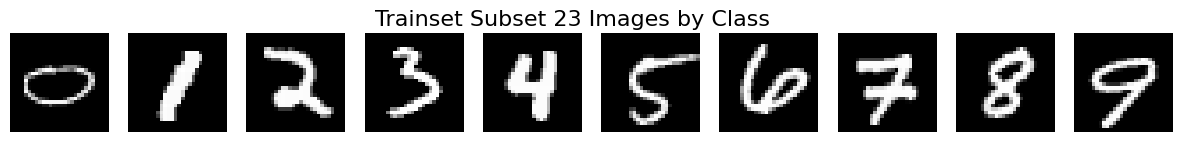

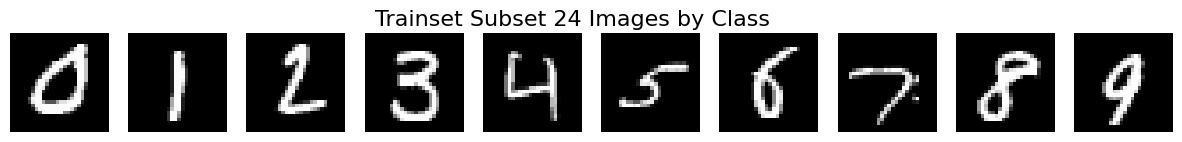

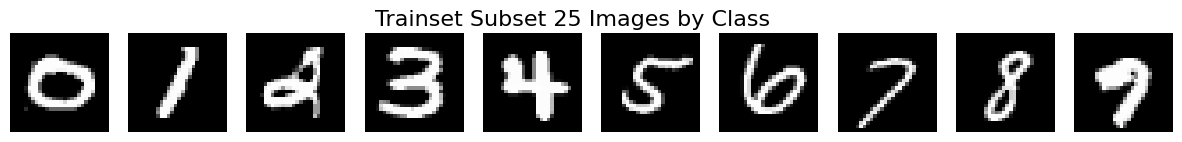

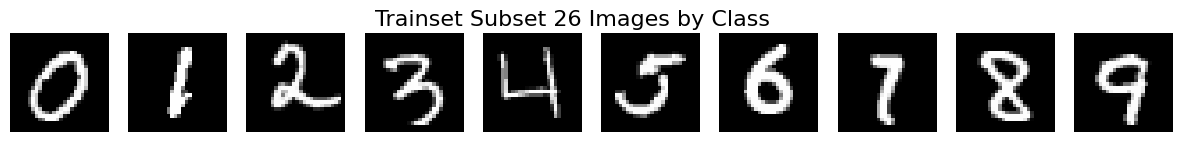

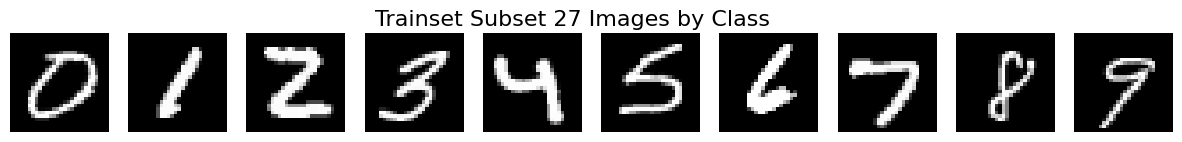

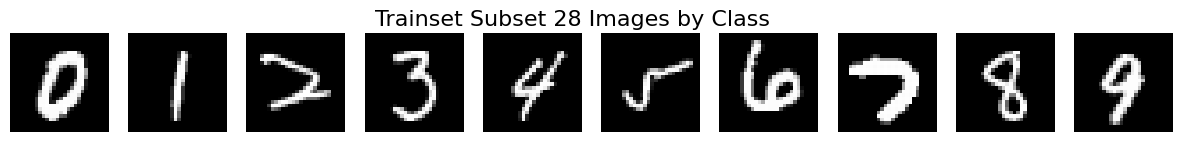

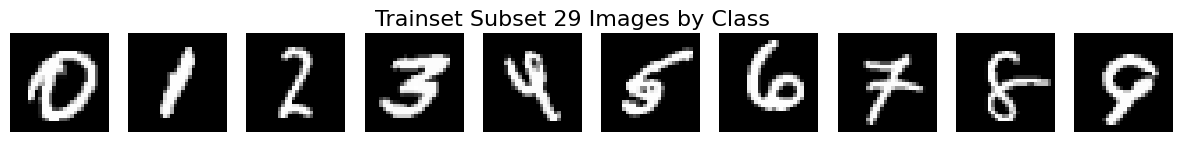

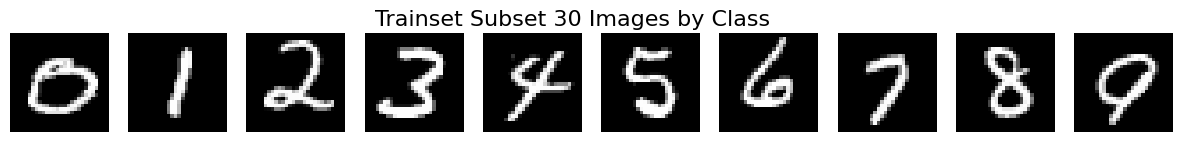

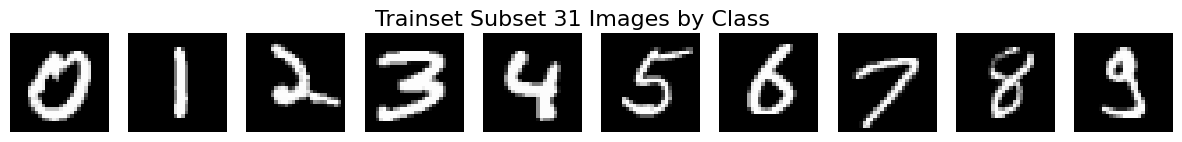

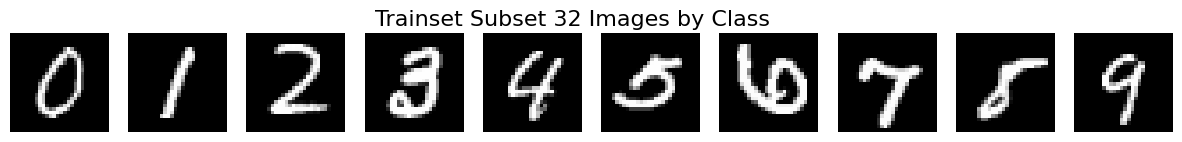

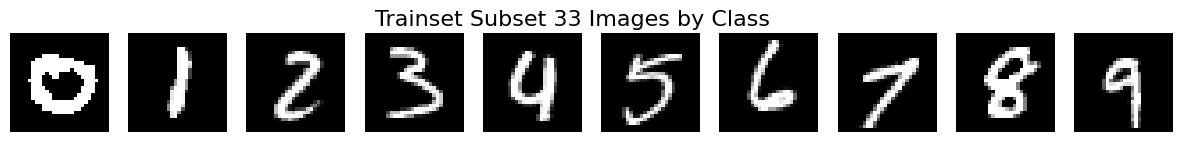

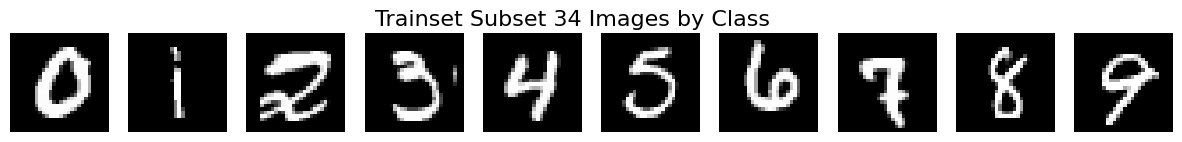

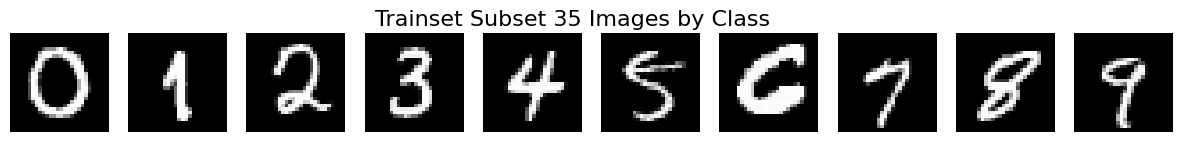

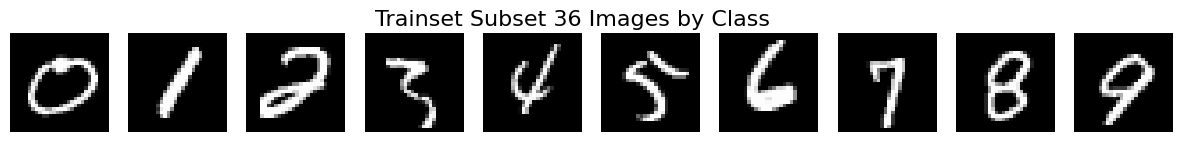

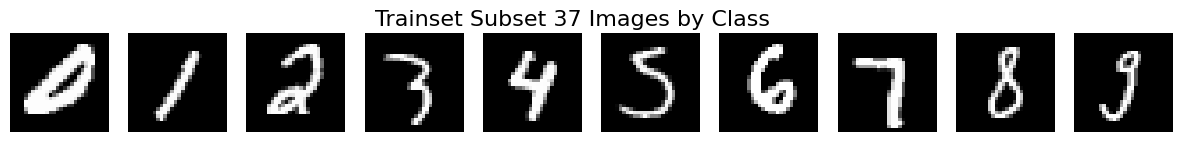

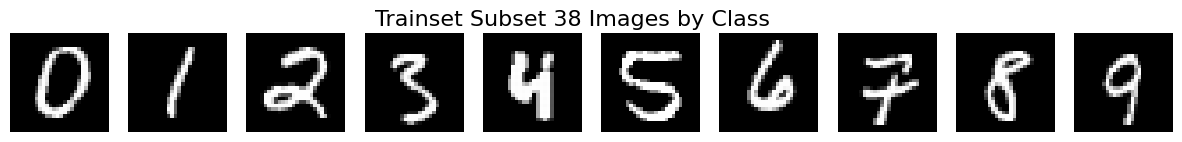

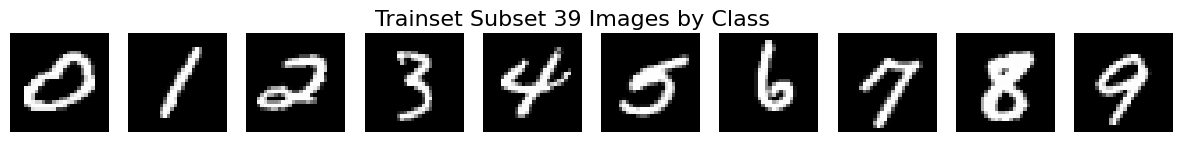

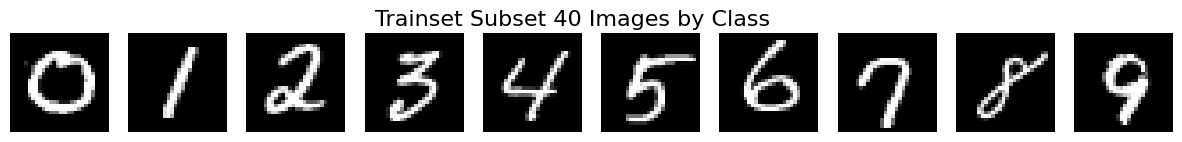

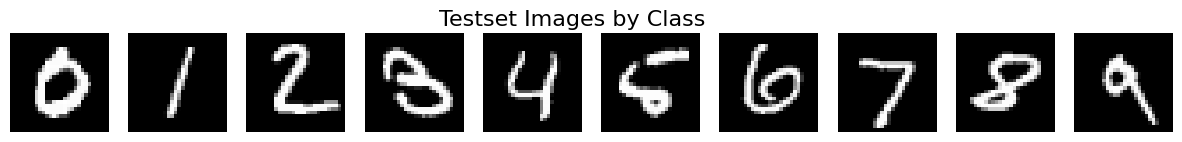

In [11]:
# Going through the dataloader to extract an image per class

train_images1 = get_images_by_class(train_loader1)
train_images2 = get_images_by_class(train_loader2)
train_images3 = get_images_by_class(train_loader3)
train_images4 = get_images_by_class(train_loader4)
train_images5 = get_images_by_class(train_loader5)
train_images6 = get_images_by_class(train_loader6)
train_images7 = get_images_by_class(train_loader7)
train_images8 = get_images_by_class(train_loader8)
train_images9 = get_images_by_class(train_loader9)
train_images10 = get_images_by_class(train_loader10)
train_images11 = get_images_by_class(train_loader11)
train_images12 = get_images_by_class(train_loader12)
train_images13 = get_images_by_class(train_loader13)
train_images14 = get_images_by_class(train_loader14)
train_images15 = get_images_by_class(train_loader15)
train_images16 = get_images_by_class(train_loader16)
train_images17 = get_images_by_class(train_loader17)
train_images18 = get_images_by_class(train_loader18)
train_images19 = get_images_by_class(train_loader19)
train_images20 = get_images_by_class(train_loader20)
train_images21 = get_images_by_class(train_loader21)
train_images22 = get_images_by_class(train_loader22)
train_images23 = get_images_by_class(train_loader23)
train_images24 = get_images_by_class(train_loader24)
train_images25 = get_images_by_class(train_loader25)
train_images26 = get_images_by_class(train_loader26)
train_images27 = get_images_by_class(train_loader27)
train_images28 = get_images_by_class(train_loader28)
train_images29 = get_images_by_class(train_loader29)
train_images30 = get_images_by_class(train_loader30)
train_images31 = get_images_by_class(train_loader31)
train_images32 = get_images_by_class(train_loader32)
train_images33 = get_images_by_class(train_loader33)
train_images34 = get_images_by_class(train_loader34)
train_images35 = get_images_by_class(train_loader35)
train_images36 = get_images_by_class(train_loader36)
train_images37 = get_images_by_class(train_loader37)
train_images38 = get_images_by_class(train_loader38)
train_images39 = get_images_by_class(train_loader39)
train_images40 = get_images_by_class(train_loader40)
test_images = get_images_by_class(test_loader)

plot_images(train_images1, "Trainset Subset 1 Images by Class")
plot_images(train_images2, "Trainset Subset 2 Images by Class")
plot_images(train_images3, "Trainset Subset 3 Images by Class")
plot_images(train_images4, "Trainset Subset 4 Images by Class")
plot_images(train_images5, "Trainset Subset 5 Images by Class")
plot_images(train_images6, "Trainset Subset 6 Images by Class")
plot_images(train_images7, "Trainset Subset 7 Images by Class")
plot_images(train_images8, "Trainset Subset 8 Images by Class")
plot_images(train_images9, "Trainset Subset 9 Images by Class")
plot_images(train_images10, "Trainset Subset 10 Images by Class")
plot_images(train_images11, "Trainset Subset 11 Images by Class")
plot_images(train_images12, "Trainset Subset 12 Images by Class")
plot_images(train_images13, "Trainset Subset 13 Images by Class")
plot_images(train_images14, "Trainset Subset 14 Images by Class")
plot_images(train_images15, "Trainset Subset 15 Images by Class")
plot_images(train_images16, "Trainset Subset 16 Images by Class")
plot_images(train_images17, "Trainset Subset 17 Images by Class")
plot_images(train_images18, "Trainset Subset 18 Images by Class")
plot_images(train_images19, "Trainset Subset 19 Images by Class")
plot_images(train_images20, "Trainset Subset 20 Images by Class")
plot_images(train_images21, "Trainset Subset 21 Images by Class")
plot_images(train_images22, "Trainset Subset 22 Images by Class")
plot_images(train_images23, "Trainset Subset 23 Images by Class")
plot_images(train_images24, "Trainset Subset 24 Images by Class")
plot_images(train_images25, "Trainset Subset 25 Images by Class")
plot_images(train_images26, "Trainset Subset 26 Images by Class")
plot_images(train_images27, "Trainset Subset 27 Images by Class")
plot_images(train_images28, "Trainset Subset 28 Images by Class")
plot_images(train_images29, "Trainset Subset 29 Images by Class")
plot_images(train_images30, "Trainset Subset 30 Images by Class")
plot_images(train_images31, "Trainset Subset 31 Images by Class")
plot_images(train_images32, "Trainset Subset 32 Images by Class")
plot_images(train_images33, "Trainset Subset 33 Images by Class")
plot_images(train_images34, "Trainset Subset 34 Images by Class")
plot_images(train_images35, "Trainset Subset 35 Images by Class")
plot_images(train_images36, "Trainset Subset 36 Images by Class")
plot_images(train_images37, "Trainset Subset 37 Images by Class")
plot_images(train_images38, "Trainset Subset 38 Images by Class")
plot_images(train_images39, "Trainset Subset 39 Images by Class")
plot_images(train_images40, "Trainset Subset 40 Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

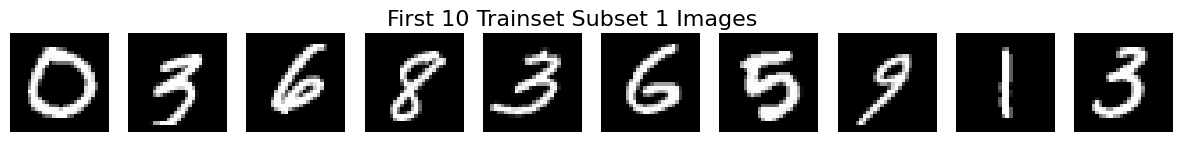

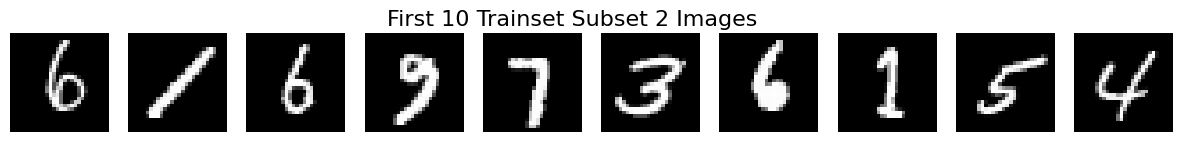

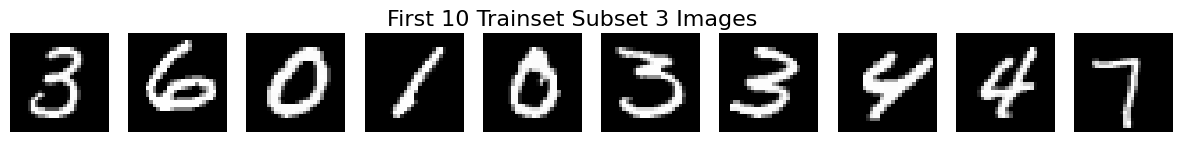

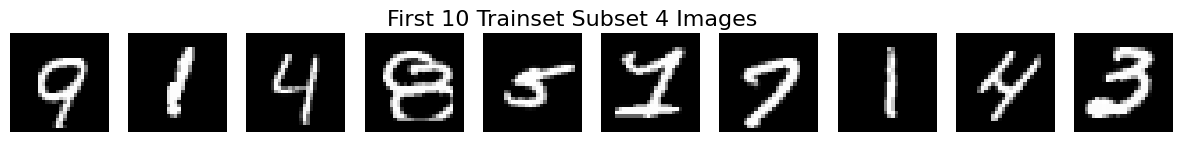

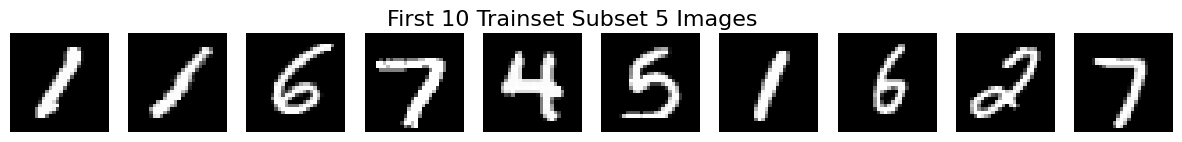

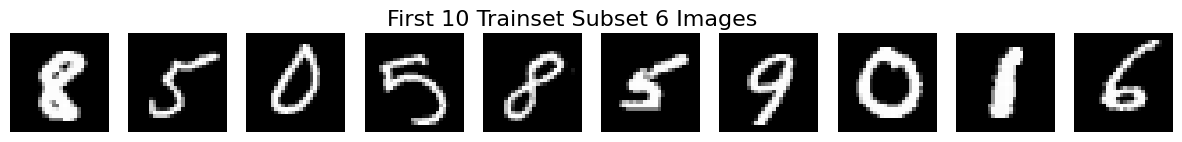

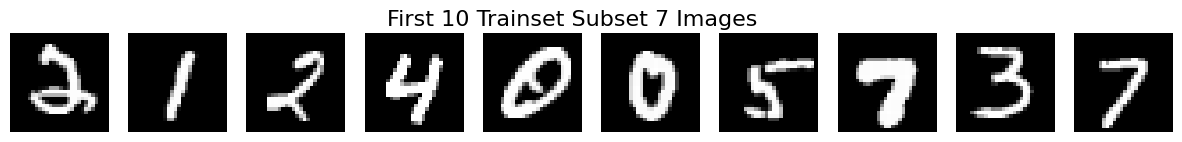

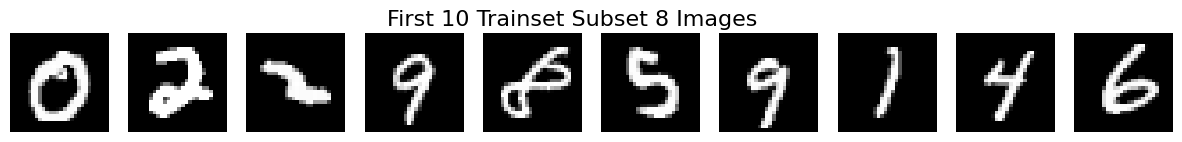

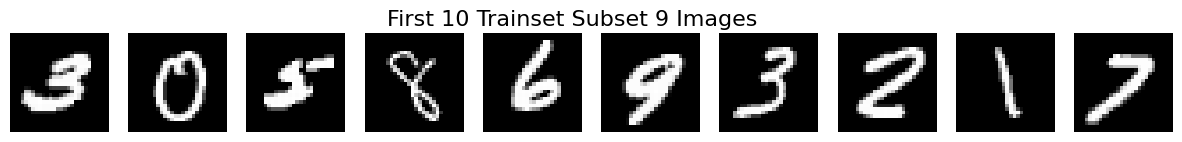

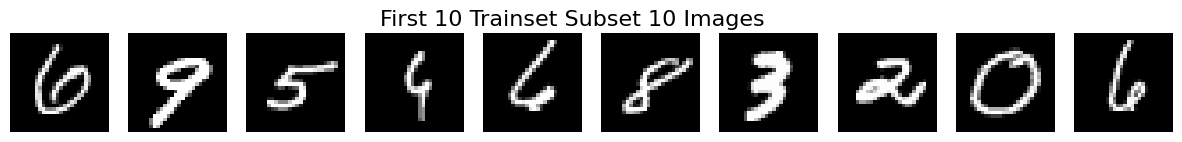

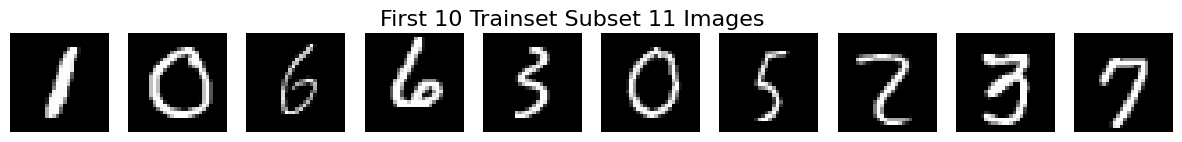

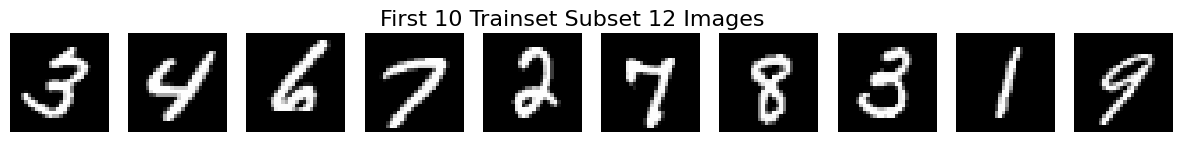

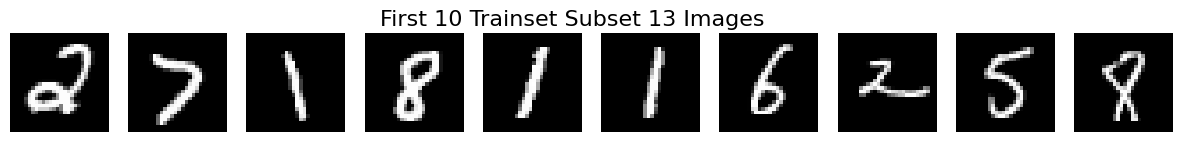

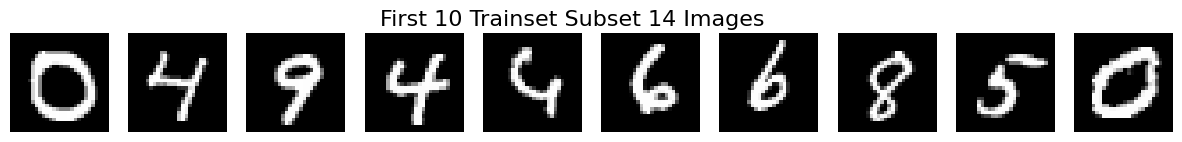

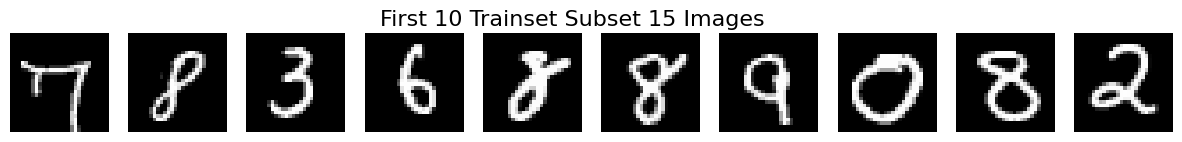

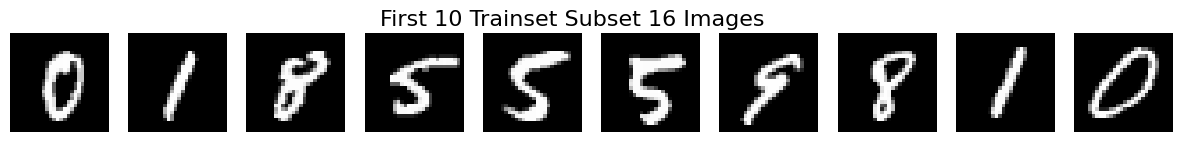

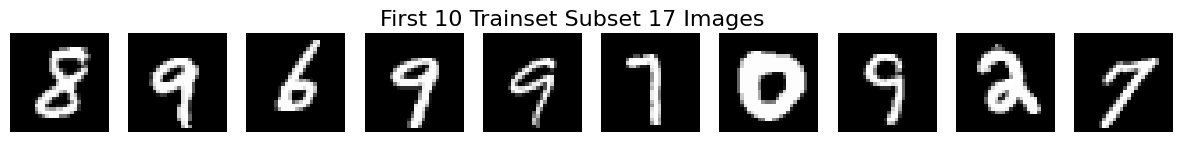

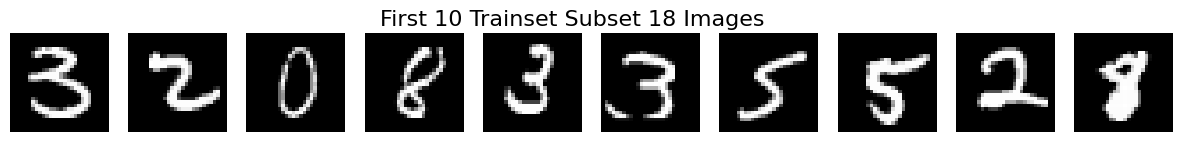

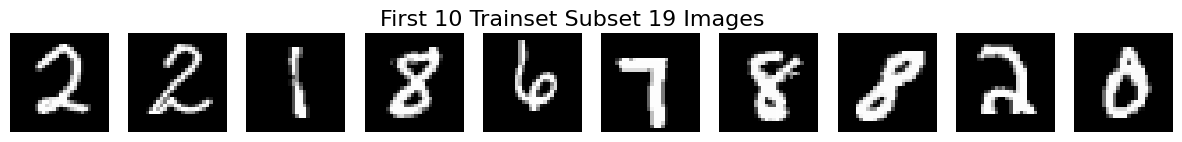

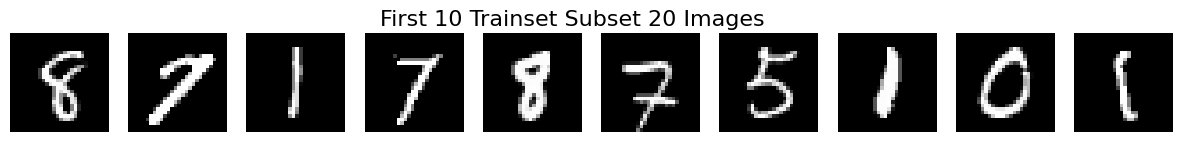

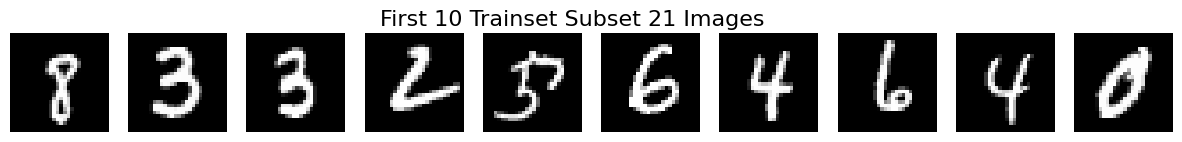

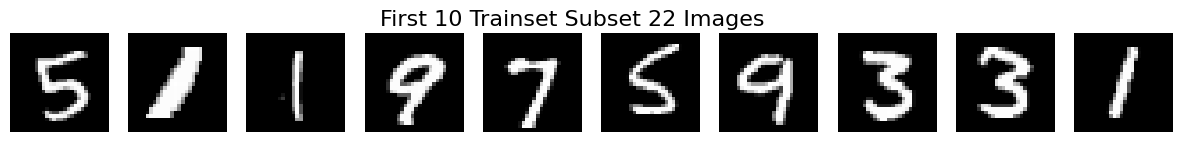

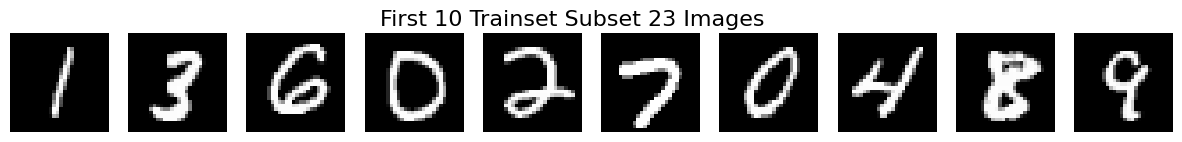

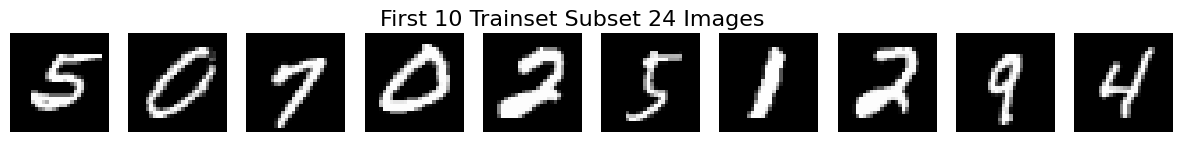

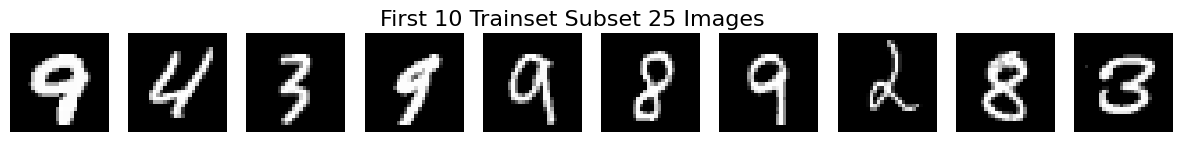

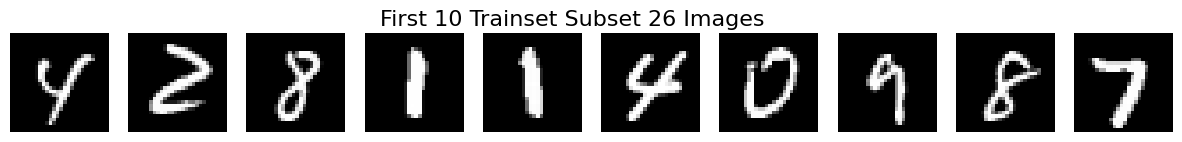

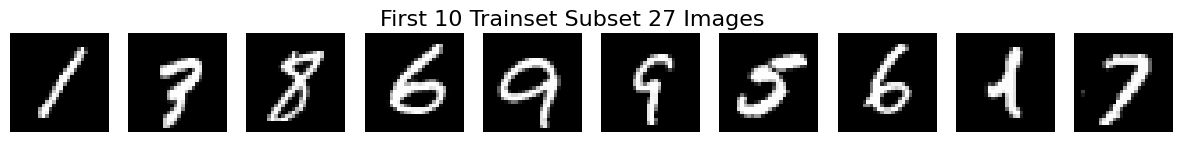

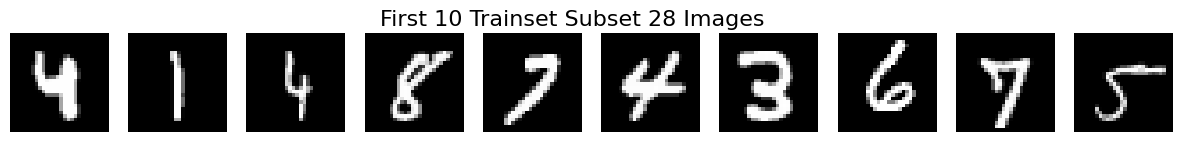

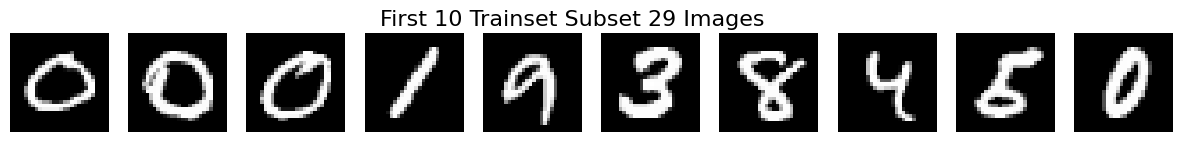

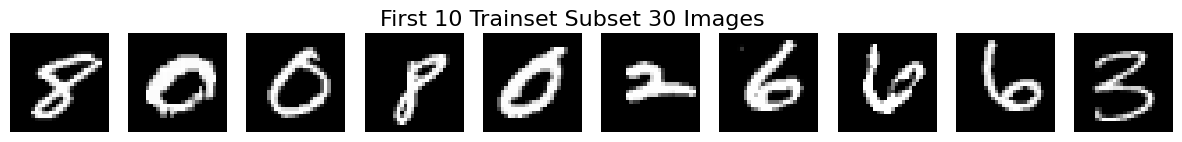

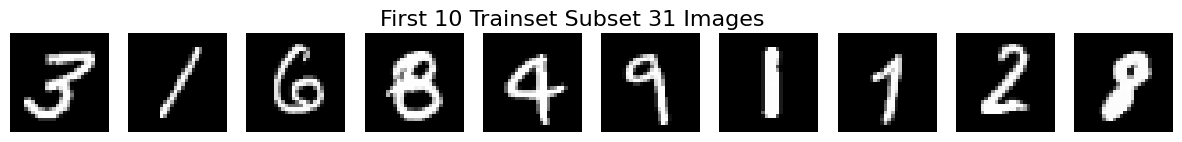

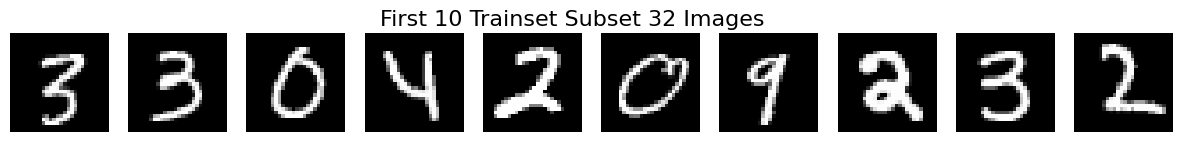

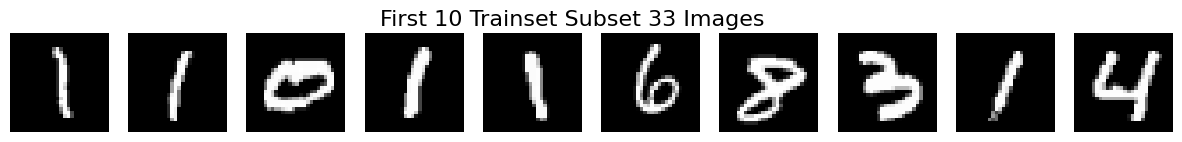

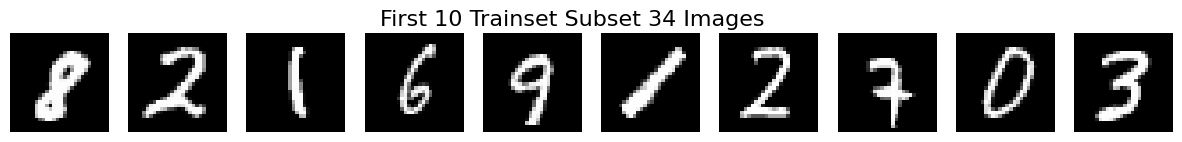

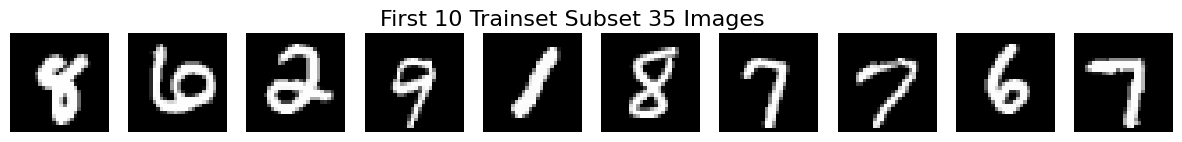

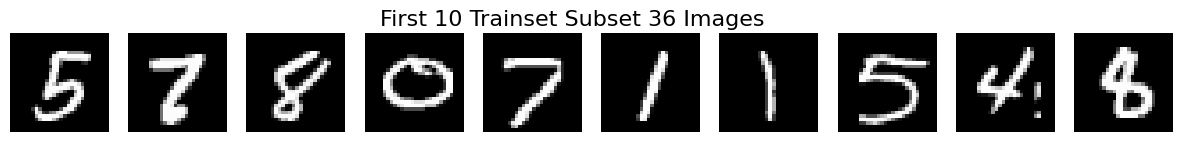

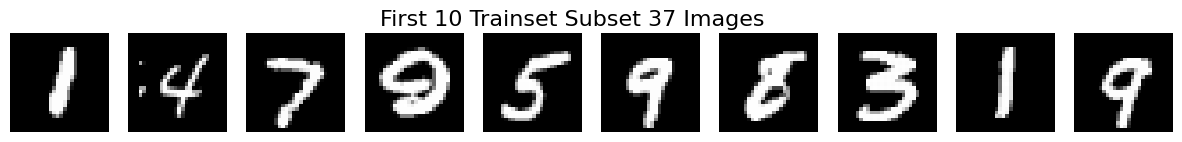

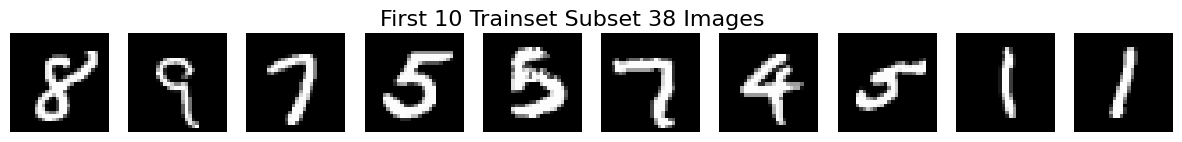

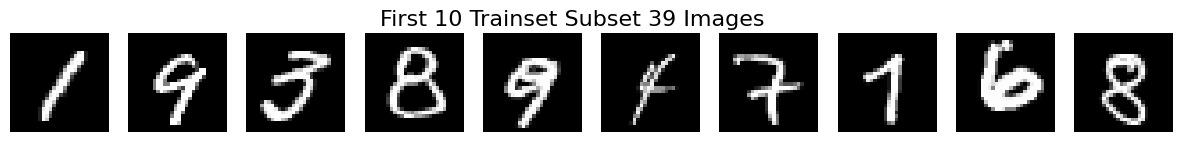

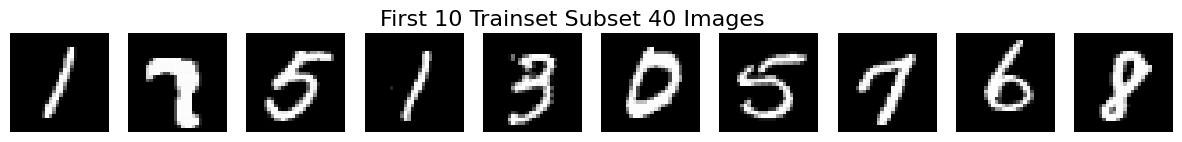

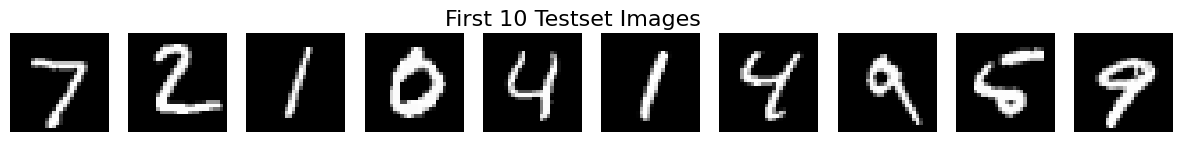

In [12]:
plot_first_images(train_loader1, "First 10 Trainset Subset 1 Images")
plot_first_images(train_loader2, "First 10 Trainset Subset 2 Images")
plot_first_images(train_loader3, "First 10 Trainset Subset 3 Images")
plot_first_images(train_loader4, "First 10 Trainset Subset 4 Images")
plot_first_images(train_loader5, "First 10 Trainset Subset 5 Images")
plot_first_images(train_loader6, "First 10 Trainset Subset 6 Images")
plot_first_images(train_loader7, "First 10 Trainset Subset 7 Images")
plot_first_images(train_loader8, "First 10 Trainset Subset 8 Images")
plot_first_images(train_loader9, "First 10 Trainset Subset 9 Images")
plot_first_images(train_loader10, "First 10 Trainset Subset 10 Images")
plot_first_images(train_loader11, "First 10 Trainset Subset 11 Images")
plot_first_images(train_loader12, "First 10 Trainset Subset 12 Images")
plot_first_images(train_loader13, "First 10 Trainset Subset 13 Images")
plot_first_images(train_loader14, "First 10 Trainset Subset 14 Images")
plot_first_images(train_loader15, "First 10 Trainset Subset 15 Images")
plot_first_images(train_loader16, "First 10 Trainset Subset 16 Images")
plot_first_images(train_loader17, "First 10 Trainset Subset 17 Images")
plot_first_images(train_loader18, "First 10 Trainset Subset 18 Images")
plot_first_images(train_loader19, "First 10 Trainset Subset 19 Images")
plot_first_images(train_loader20, "First 10 Trainset Subset 20 Images")
plot_first_images(train_loader21, "First 10 Trainset Subset 21 Images")
plot_first_images(train_loader22, "First 10 Trainset Subset 22 Images")
plot_first_images(train_loader23, "First 10 Trainset Subset 23 Images")
plot_first_images(train_loader24, "First 10 Trainset Subset 24 Images")
plot_first_images(train_loader25, "First 10 Trainset Subset 25 Images")
plot_first_images(train_loader26, "First 10 Trainset Subset 26 Images")
plot_first_images(train_loader27, "First 10 Trainset Subset 27 Images")
plot_first_images(train_loader28, "First 10 Trainset Subset 28 Images")
plot_first_images(train_loader29, "First 10 Trainset Subset 29 Images")
plot_first_images(train_loader30, "First 10 Trainset Subset 30 Images")
plot_first_images(train_loader31, "First 10 Trainset Subset 31 Images")
plot_first_images(train_loader32, "First 10 Trainset Subset 32 Images")
plot_first_images(train_loader33, "First 10 Trainset Subset 33 Images")
plot_first_images(train_loader34, "First 10 Trainset Subset 34 Images")
plot_first_images(train_loader35, "First 10 Trainset Subset 35 Images")
plot_first_images(train_loader36, "First 10 Trainset Subset 36 Images")
plot_first_images(train_loader37, "First 10 Trainset Subset 37 Images")
plot_first_images(train_loader38, "First 10 Trainset Subset 38 Images")
plot_first_images(train_loader39, "First 10 Trainset Subset 39 Images")
plot_first_images(train_loader40, "First 10 Trainset Subset 40 Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Defining some variables and creating files & folders**

In [13]:
HDFP = "./volumes/Ultra Touch" # Load HHD

SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

---

## **First version : LeNet without Incremental Learning**

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.02
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Without-Incremental-Learning", 
           tags=["LeNet", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataset[:]",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )

print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

---

## **Second version : LeNet with Incremental Learning**

##### **Training on trainloader1**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning = nn.DataParallel(model_with_incremental_learning)
    model_with_incremental_learning.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning.to(device)

# Training code
NUM_EPOCHES = 45
learning_rate = 0.01
isLoop = True
optimizer = torch.optim.SGD(model_with_incremental_learning.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning", 
           tags=["LeNet", "With-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataloader1",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )



print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader1):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader1...")

##### **Training on trainloader2**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader2...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader2):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

##### **Training on trainloader3**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader3...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader3):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader3.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader3...")
# Finish the wandb run
wandb.finish()

---

## **Third version : LeNet with Incremental Learning, LC-checkpoint, and Delta-LoRA**

##### **Training on trainloader1**

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning_lc_dlora = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning_lc_dlora = nn.DataParallel(model_with_incremental_learning_lc_dlora)
    model_with_incremental_learning_lc_dlora.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning_lc_dlora.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.1
learning_rate_dloralc = 0.1
learning_rate1 = 0.005
# super_step = len(train_loader2)
# super_step = 20
isLoop = True

optimizer = torch.optim.SGD(model_with_incremental_learning_lc_dlora.parameters(), lr=learning_rate1)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning_LC_DLORA-Without-Restore_40x2.5", 
           tags=["LeNet", "With-Incremental-Learning_LC_DLORA", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "splitting": "2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5-2.5",
                    "train dataset 1": "MNIST train dataloader1",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate_nothing": learning_rate,
                    "learning_rate_dloralc": learning_rate_dloralc,
                    "optimizer": "SGD"
                }
           )

print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning_lc_dlora.train()
        for iter, data in enumerate(train_loader1):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning_lc_dlora(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning_lc_dlora.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning_lc_dlora(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.7:
        rounded_valid_acc = round(valid_accuracy, 4)
        # torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vit/branch_{}.pt".format(rounded_valid_acc))
        torch.save(model_with_incremental_learning_lc_dlora.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
        print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))
        isLoop = False
        break
    # if valid_accuracy > 0.90:
    #     isLoop = False
    #     break

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss,
        "valid_loss_lc": valid_loss,
        "train_accuracy_lc": train_accuarcy,
        "valid_accuracy_lc": valid_accuracy, 
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch,
    })
    # wandb.log({
    #     "train_loss_dloralc": train_loss,
    #     "valid_loss_dloralc": valid_loss,
    #     "train_accuracy_dloralc": train_accuarcy,
    #     "valid_accuracy_dloralc": valid_accuracy,
    #     "train_loss_lc": train_loss,
    #     "valid_loss_lc": valid_loss,
    #     "train_accuracy_lc": train_accuarcy,
    #     "valid_accuracy_lc": valid_accuracy, 
    #     "train_loss": train_loss,
    #     "valid_loss": valid_loss,
    #     "train_accuracy": train_accuarcy,
    #     "valid_accuracy": valid_accuracy,
    #     "valid_loss_dloralc_restored": valid_loss,
    #     "valid_accuracy_dloralc_restored": valid_accuracy,
    #     "epoch": epoch,
    # })

print("End of model training on dataloader1...")

Let's use 1 GPU!


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▁▂▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇██████████
train_accuracy_dloralc,▁▁▂▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇██████████
train_accuracy_lc,▁▁▂▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇██████████
train_loss,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁▁
train_loss_dloralc,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁▁
train_loss_lc,███████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁▁
valid_accuracy,▁▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
valid_accuracy_dloralc,▁▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
valid_accuracy_lc,▁▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
valid_loss,███████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁


Start of model training on dataloader1...
Epoch: [0/49], Training Loss: 2.310548, Validation Loss: 2.301222, Training Accuracy: 0.139799, Validation Accuracy: 0.142700
Epoch: [1/49], Training Loss: 2.301519, Validation Loss: 2.292333, Training Accuracy: 0.151171, Validation Accuracy: 0.155400
Epoch: [2/49], Training Loss: 2.292629, Validation Loss: 2.283367, Training Accuracy: 0.161204, Validation Accuracy: 0.162800
Epoch: [3/49], Training Loss: 2.283588, Validation Loss: 2.274046, Training Accuracy: 0.170569, Validation Accuracy: 0.173800
Epoch: [4/49], Training Loss: 2.274122, Validation Loss: 2.264351, Training Accuracy: 0.181271, Validation Accuracy: 0.184100
Epoch: [5/49], Training Loss: 2.264236, Validation Loss: 2.254173, Training Accuracy: 0.183278, Validation Accuracy: 0.202900
Epoch: [6/49], Training Loss: 2.253802, Validation Loss: 2.243162, Training Accuracy: 0.203344, Validation Accuracy: 0.244400
Epoch: [7/49], Training Loss: 2.242455, Validation Loss: 2.231271, Training 

### **Working iteratively on training with delta-LoRA and LC-checkpoint on each train dataloader** 

In [16]:
NUM_EPOCHES = 20
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.3.weight"]
RANK = -1
SCALING = -1
BRANCH_ACC = "0.705"

original = LeNet().to(device)
model_original = LeNet().to(device)
model_no_touch = LeNet().to(device)

BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))
model_no_touch.load_state_dict(torch.load(BRANCH_LOC))

w, b = getBase(original)
model = LeNet_LowRank(w, b, rank = RANK).to(device)

print(model.state_dict().keys())

load_sd_decomp(torch.load(BRANCH_LOC, map_location=device), model, DECOMPOSED_LAYERS)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)
optimizer_lc_only = torch.optim.SGD(model_original.parameters(), lr=learning_rate)
optimizer_no_touch = torch.optim.SGD(model_no_touch.parameters(), lr=learning_rate)

acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

train_loader_list = [train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10,
                     train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20,
                     train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30,
                     train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40]

for i in range(len(train_loader_list)):

    # Initialize the current iteration and set to 0
    current_iter = 0
    current_set = 0

    # Initialize the current iteration and set to 0 for the old LC method
    current_iter_old_lc = 0
    current_set_old_lc = 0

    print("-----------------------------------")

    txt_MNIST_train = "MNIST train dataloader{}".format(i+2)
    txt_train_dataset = "train dataset {}".format(i+2)

    wandb.config["branch_accuracy"] = BRANCH_ACC
    wandb.config[txt_train_dataset] = txt_MNIST_train

    # Training code on dataloader2
    print("Start of model training on dataloader{}...".format(i+2))

    isLoop = True

    valid_accuracy_list = []

    base = None

    for epoch in range(NUM_EPOCHES):
        if not isLoop:
            break
        else:
            train_loss = 0.0
            train_loss_lc = 0.0
            train_loss_no_touch = 0.0
            valid_loss = 0.0
            valid_loss_lc = 0.0
            valid_loss_no_touch = 0.0

            train_correct = 0
            train_correct_lc = 0
            train_correct_no_touch = 0
            train_total = 0
            train_total_lc = 0
            train_total_no_touch = 0

            valid_correct = 0
            valid_correct_lc = 0
            valid_correct_no_touch = 0
            valid_total = 0
            valid_total_lc = 0
            valid_total_no_touch = 0
            
            model.train()
            model_original.train()
            model_no_touch.train()

            for iter, data in enumerate(train_loader_list[i]):

                # Check if it is the first iteration of the first epoch
                if iter == 0: # first iteration, create baseline model
                # if iter == 0 and epoch == 0: # first iteration, create baseline model
                    ########################################################
                    ### DELTA-LORA + LC
                    ########################################################
                    
                    base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                            "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                    ########################################################
                    ### LC
                    ########################################################

                    cstate = model_original.state_dict()
                    set_path = "/set_{}".format(current_set_old_lc)
                    if not os.path.exists(SAVE_LOC_OLC + set_path):
                        os.makedirs(SAVE_LOC_OLC + set_path)
                    prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
                
                else:
                    
                    ########################################################
                    ### DELTA-LORA + LC 
                    ########################################################

                    # Delta-compression: The delta for the weights of the normal and decomposed layers.
                    # Also returns the full dictionary, which holds the bias.

                    #Calculate the time before generate_delta_gpu function
                    delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                    base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                    # Compressing the delta and decomposed delta
                    compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                                decomp_delta)
                    # Saving checkpoint
                    # lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                    #                 "/set_{}".format(current_set))
                
                    # Update base and base_decomp
                    base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                    base_decomp = np.add(full_dcomp_delta, base_decomp)

                    # Update current iteration
                    current_iter += 1

                    ########################################################
                    ### LC
                    ########################################################

                    cstate = model_original.state_dict()
                    old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                    olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                    # olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                    #                     old_lc_bias, current_iter_old_lc)
                    prev_state = np.add(prev_state, update_prev)
                    current_iter_old_lc += 1

                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                ########################################################
                ### DELTA-LORA + LC
                ########################################################

                optimizer.zero_grad()
                output = model(inputs)

                loss = torch.nn.CrossEntropyLoss()(output, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(output, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)

                train_acc = torch.eq(output.argmax(-1), labels).float().mean()

                ########################################################
                ### LC
                ########################################################

                optimizer_lc_only.zero_grad()
                output_lc = model_original(inputs)

                loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
                loss_lc.backward()
                optimizer_lc_only.step()
                train_loss_lc += loss_lc.item() * inputs.size(0)

                _, predicted_lc = torch.max(output_lc, 1)
                train_correct_lc += (predicted_lc == labels).sum().item()
                train_total_lc += labels.size(0)

                train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

                ########################################################
                ### NO TOUCH
                ########################################################

                optimizer_no_touch.zero_grad()
                output_no_touch = model_no_touch(inputs)

                loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
                loss_no_touch.backward()
                optimizer_no_touch.step()
                train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

                _, predicted_no_touch = torch.max(output_no_touch, 1)
                train_correct_no_touch += (predicted_no_touch == labels).sum().item()
                train_total_no_touch += labels.size(0)

                train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

            model.eval()
            model_original.eval()
            model_no_touch.eval()
            with torch.no_grad():  # Gradient computation is not needed for validation
                for data, target in test_loader:
                    # Move data and target to the correct device
                    data, target = data.to(device), target.to(device)

                    ########################################################
                    ### DELTA-LORA + LC
                    ########################################################

                    output = model(data)
                    loss = torch.nn.CrossEntropyLoss()(output, target)
                    valid_loss += loss.item() * data.size(0)

                    _, predicted = torch.max(output, 1)
                    valid_correct += (predicted == target).sum().item()
                    valid_total += target.size(0)

                    valid_acc = torch.eq(output.argmax(-1), target).float().mean()

                    ########################################################
                    ### LC
                    ########################################################

                    output_lc = model_original(data)
                    loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
                    valid_loss_lc += loss_lc.item() * data.size(0)

                    _, predicted_lc = torch.max(output_lc, 1)
                    valid_correct_lc += (predicted_lc == target).sum().item()
                    valid_total_lc += target.size(0)

                    valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

                    ########################################################
                    ### NO TOUCH
                    ########################################################

                    output_no_touch = model_no_touch(data)
                    loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
                    valid_loss_no_touch += loss_no_touch.item() * data.size(0)

                    _, predicted_no_touch = torch.max(output_no_touch, 1)
                    valid_correct_no_touch += (predicted_no_touch == target).sum().item()
                    valid_total_no_touch += target.size(0)

                    valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

                    
        # Calculate average losses
        train_loss /= len(train_loader_list[i].dataset)
        train_loss_lc /= len(train_loader_list[i].dataset)
        train_loss_no_touch /= len(train_loader_list[i].dataset)
        valid_loss /= len(test_loader.dataset)
        valid_loss_lc /= len(test_loader.dataset)
        valid_loss_no_touch /= len(test_loader.dataset)

        train_accuarcy = train_correct / train_total
        train_accuarcy_lc = train_correct_lc / train_total_lc
        train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
        valid_accuracy = valid_correct / valid_total
        valid_accuracy_lc = valid_correct_lc / valid_total_lc
        valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch

        valid_accuracy_list.append(valid_accuracy)
        
        print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
            \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
            \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, 
            train_loss, valid_loss, train_accuarcy, valid_accuracy, 
            train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
            train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch)) 

        wandb.log({
            "train_loss_dloralc": train_loss,
            "valid_loss_dloralc": valid_loss,
            "train_accuracy_dloralc": train_accuarcy,
            "valid_accuracy_dloralc": valid_accuracy,
            "train_loss_lc": train_loss_lc,
            "valid_loss_lc": valid_loss_lc,
            "train_accuracy_lc": train_accuarcy_lc,
            "valid_accuracy_lc": valid_accuracy_lc,
            "train_loss": train_loss_no_touch,
            "valid_loss": valid_loss_no_touch,
            "train_accuracy": train_accuarcy_no_touch,
            "valid_accuracy": valid_accuracy_no_touch,
            "epoch": epoch
        })


    print("End of model training on dataloader{}...".format(i+2))

    # Store accuracy

    BRANCH_ACC = valid_accuracy
    print("Model saved at accuracy: {:.4f}".format(BRANCH_ACC))
    torch.save(model.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}_{}.pt".format(i+2,BRANCH_ACC))

    w, b = getBase(original)
    model = LeNet_LowRank(w, b, rank = RANK).to(device)

    model.load_state_dict(torch.load(HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}_{}.pt".format(i+2,BRANCH_ACC)))

    print(model.state_dict().keys())

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])
-----------------------------------
Start of model training on dataloader2...
Epoch: [0/19], Training Loss DLoRALC: 1.004733, Validation Loss DLoRALC: 0.922184, Training Accuracy DLoRALC: 0.745503, Validation Accuracy DLoRALC: 0.768600 
             	 Training Loss LC: 0.902957, Validation Loss LC: 0.747370, Training Accuracy LC: 0.780147, Validation Accuracy LC: 0.823700, 
             	 Training Loss: 0.902957, Validation Loss: 0.747370, Training Accuracy: 0.780147, Validation Accuracy: 0.823700
Epoch: [1/19], Training Loss DLoRALC: 0.806354, Validation Loss DLoRALC: 0.781294, Training Accuracy DLoRALC: 0.800799, Validation Accuracy DLoRALC: 0.802000 
             	 Training Loss LC: 0.601700, Validation Loss LC: 0.571180, Trai

In [17]:
wandb.finish()

epoch,▃█▄▂▄▂▄▅▄▅▄▅▆▅▆▅▆▁▆▁▆▁▆▁▂▁▂▁▂▄▂▄▂▄▅▄▅▄▅▆
train_accuracy,▁▄▇█████████████████████████████████████
train_accuracy_dloralc,▁▄▇█████████████████████████████████████
train_accuracy_lc,▁▄▇█████████████████████████████████████
train_loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_dloralc,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_lc,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▄▇▇████████████████████████████████████
valid_accuracy_dloralc,▁▄▇▇████████████████████████████████████
valid_accuracy_lc,▁▄▇▇████████████████████████████████████
valid_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
